# Clustering 

In this script, we implemented K-means clustering of the songs based on the lyrics. For this purpose, we converted the lyrics to vectors using the TF-IDF technique. Next, we used the KMeans clustering algorithm to allocate the songs to ten clusters. We show the most frequent primary artists and most frequent words in each cluster. 

In the case of the artists, we can see some interesting examples from the first cluster where we have artists like Michael Jackson, Madonna, Prince, Wham!. 

In the case of words, we can see that multiple clusters have same or similar words appearing as most frequent. We believe that the clustering was done based on some less frequently occuring words that uniquely identify the clusters. This can be better observed in the case of artists where artists from similar genres are grouped together.

In [1]:
import json
import numpy as np
from pandas.io.json import json_normalize
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn import utils
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

In [2]:
with open('../data/top_hits_merged_clean_lyrics_audio_features.json') as json_file:
    top_hits = json.load(json_file)
    
with open('../data/not_hits_merged_clean_lyrics_audio_features.json') as json_file:
    not_hits = json.load(json_file)

In [3]:
top_hits_df = pd.read_json(top_hits)
not_hits_df = pd.read_json(not_hits)

top_hits_df['class'] = 1
not_hits_df['class'] = 0

df = pd.concat([top_hits_df, not_hits_df])

In [4]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [5]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [6]:
X = df['clean_lyrics'] # the features we want to analyze

In [7]:
v = TfidfVectorizer()

X_tfidf = v.fit_transform(X) 

In [8]:
km = KMeans(n_clusters = 10, init='k-means++')
km.fit(X_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
clusters = km.predict(X_tfidf)
df['cluster'] = clusters

In [10]:
df['primary_artist'] = df['artists'].apply(lambda x: x[0]['name'])

In [11]:
# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

## Most frequent artists in each cluster

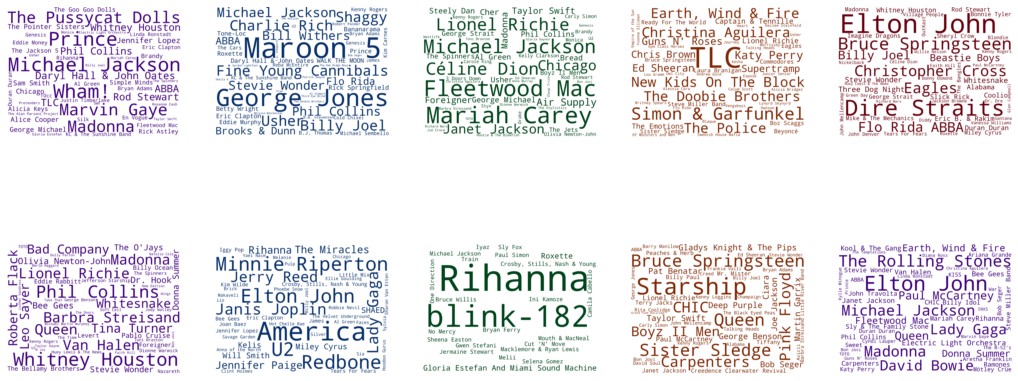

In [12]:
# generate subplot axes
fig, axes = plt.subplots(2, 5, figsize=(18,8))
axes = axes.ravel()

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'Purples', 'Blues', 'Greens', 'Oranges', 'Purples']

for i in range(10):
    color_func = colormap_size_func(cmaps[i], 10)
    temp_df = df[df['cluster']==i]
    freq_dict = temp_df['primary_artist'].value_counts().to_dict()
    wordcloud = WordCloud(background_color='white', height=1800, min_font_size=2,
                      width=2400, color_func=color_func,
                      max_words=50)
    wordcloud = wordcloud.generate_from_frequencies(freq_dict)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')

## Most frequent words in each cluster

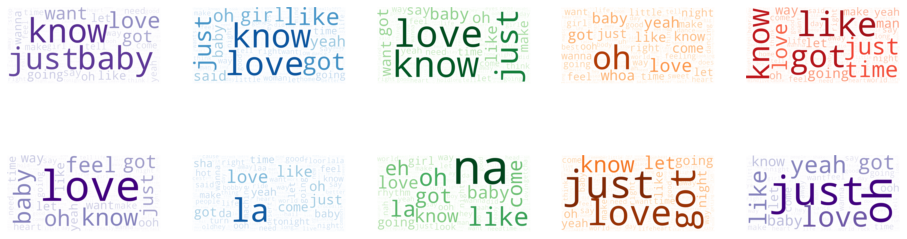

In [13]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

# calculate word frequencies
stop_words = list(ENGLISH_STOP_WORDS) + ['im', 'dont']
# generate subplot axes
fig, axes = plt.subplots(2, 5, figsize=(16,5))
axes = axes.ravel()

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'Purples', 'Blues', 'Greens', 'Oranges', 'Purples']

for i in range(10):
    color_func = colormap_size_func(cmaps[i], 300)
    lyrics = df[df['cluster']==i]['clean_lyrics'].dropna().values.tolist()
    count = CountVectorizer(stop_words=stop_words)
    count.fit(np.array(lyrics))
    freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)

    # make word cloud
    word_freq_dict = dict(zip(count.get_feature_names(), freqs))
    wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=color_func,
                      max_words=800)
    wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')